# Powerlaw Interface Sections For Export

Chris Field, January 2022

*Create sections from pre-made Pareto faulted interfaces and export as png format velocity models.*
Approach:
* Load in random interface and QC (plot spectral slope)
* Use the list to insert velocity values at the specified depth
* Vertical running sum
* Add a constant value to all cells
* Plot in matplotlib

In [1]:
import os  # operating system
import sys # to add src directory for my modules
#
import numpy as np
import math
import random
#
from scipy import stats
from scipy import signal
#
from skimage.io import imread, imsave
#
from datetime import datetime
#
# Plotting requirements
import matplotlib.pyplot as plt
import matplotlib.font_manager # different fonts
from matplotlib import rcParams # runtime config to set fonts

In [2]:
# Using rcParams set the global fonts for Matplotlib
# Global parameters for Matplotlib: set font etc.
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Gill Sans MT']
rcParams['font.serif'] = ['Garamond']
rcParams['font.size'] = '16'
#

## Define functions

In [3]:
def single_plot(samp_sum_list, D_total=50, title='Samp_sum_list', step = 1):
    """
    Plot a list or array, e.g. final samp_sum_list
    
    samp_sum_list -- running sum along the spatial grid of samples, this is our random interface
    D_total -- maximum depth to plot for the random interface plot
    step -- scale the x-axis (by default we assume steps of 1 metre)
    """
    x_init = np.arange(len(samp_sum_list)) 
    x = x_init * step
    # plot
    fig = plt.figure(figsize=(14,7)) 
    ax = fig.add_subplot(1,1,1)

    ax.set_title(title)
    
    ax.set_xlabel('Distance (m)')
    ax.set_ylabel('Depth (m)')
    
    ax.step(x, samp_sum_list, linewidth=2.5, alpha=0.9, color='#d62728')
    ax.set_ylim([0,D_total])
    plt.gca().invert_yaxis()

        # cosmetics
    ## Remove axis lines.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ## Remove tick marks.
    # ax.tick_params(bottom=False, left=False)

    ## Add bar lines as a horizontal grid.
    # ax.yaxis.grid(color='white')

    plt.tight_layout()
    
    plt.show()

In [4]:
def psd_and_slope_plot(topography_array, step=1, title='Periodogram Power Spectral Density versus Wave Number', 
                       f_der_strt=1, f_der_fin=-2000, label_slope=True):
    """
    Takes in an array that is the topographic profile (for example the random interface),
    derives Power Spectral Density,
    does a regression to get the slop
    plots the power spectral density and the regression 
    
    topographic array -- list or ndarray of the depths
    step -- the x-increment step of the array, default =1m
    """
    fs = 1/step
    # Look at the power spectral density
    freqs, psd = signal.periodogram(topography_array, fs=fs)

    # Do a regression and work out the slope
    res = stats.linregress(np.log10(freqs[f_der_strt:f_der_fin]), np.log10(psd[f_der_strt:f_der_fin]))
    print(res)
    print(f'The slope is {round(res.slope,2)}')

    # Start plot
    fig = plt.figure(figsize=(14,7)) 
    ax = fig.add_subplot(1,1,1)

    # log x and y axis
    ax.plot(np.log10(freqs[1:-1]), np.log10(psd[1:-1]), alpha =0.6, color='#1f77b4', solid_capstyle="butt", lw=3)
    
    label = 'Slope = ' + str(round(res.slope,2))
    ax.plot(np.log10(freqs[f_der_strt:f_der_fin]), res.intercept + res.slope*np.log10(freqs[f_der_strt:f_der_fin]),  alpha=0.95, color='grey', 
            linewidth=3)

    if label_slope:
        ax.text(-1, 4 , label, color='grey')

    ax.set(title=title)
    ax.set_xlabel('Log(k)')
    ax.set_ylabel('Log(Power)')

    # cosmetics
    ## Remove axis lines.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.tight_layout()

    # Show and save the graph
    plt.show()

In [5]:
def numpy_grid(L=5000, D=5000):
    """
    Create a blank (zero value) of dimensions L x D
    
    Variables:
    L -- cross-section length, int
    D -- maximum depth of array, int
    
    Returns:
    grid -- ndarray of zero values of speicifed dimensions  

    """
    size=(D,L)
    grid = np.zeros(size, dtype='uint16', order='C')

    return grid

In [6]:
def interface_grid(grid, samples, vel=4000):
    """
    Insert an interface into the grid with the velocity values at the samples depths
    
    Variables:
    grid -- ndarray, int
    samples -- depths to insert velocity values, array or list
    vel -- velocity value to insert, float or int
    
    Returns:
    int_grid -- ndarray with velocity values at speicifed depths  

    """    
    x = np.arange(len(samples))
    y = samples
    
    for _x, _y in zip(x,y):
        grid[_y][_x] = vel
        pass

    return grid    

In [7]:
def sum_and_shift(int_grid, shift = 2000, conv=True):
    """
    Vertical running sum of the grid and then add constant value
    
    Variables:
    int_grid -- input ndarray, int
    shift -- value to be added to all grid points
    conv -- convert to uint16, boolean

    
    Returns:
    sum_grid -- summed and shifted grid  

    """    
    sum_grid = np.cumsum(int_grid,axis=0)
    sum_grid += shift
    
    if conv:
        sum_grid = sum_grid.astype(np.uint16)
        
    return sum_grid    

## Input and Output

In [8]:
location_out='./Output/Pareto_fault_models/'
location_in = location_out

# If necessary make output folders
if not os.path.exists(location_out) :
    os.makedirs(location_out)

## Interface 1: c=1.5

### Load in interface and QC plot

In [9]:
# Load the interface, he values must be integer for setting up the grid
samples = np.loadtxt(location_in+'Pareto_fault_interface_b_1p5.txt', dtype='uint16')

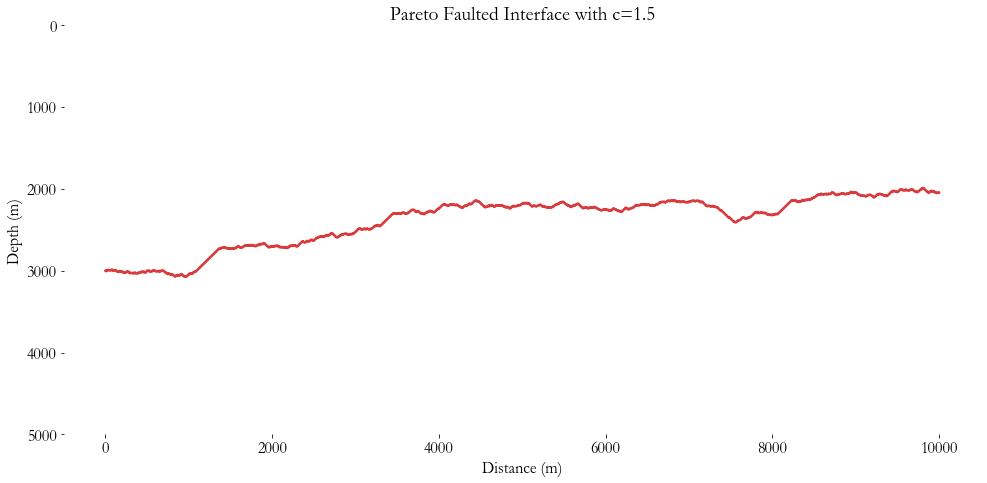

In [10]:
single_plot(samples, D_total=5000, title='Pareto Faulted Interface with c=1.5', step = 1)

LinregressResult(slope=-1.993301136045617, intercept=0.6833388771523414, rvalue=-0.9945944389106695, pvalue=0.0, stderr=0.005376735502546909)
The slope is -1.99


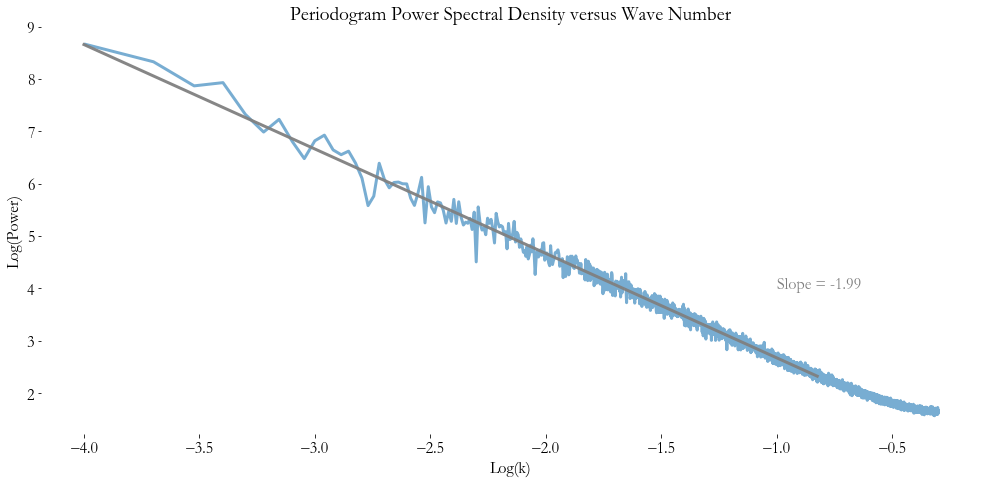

In [11]:
psd_and_slope_plot(samples, f_der_strt=1, f_der_fin=-3500)

### Create model

In [12]:
grid = numpy_grid(L=10000, D=5000)

In [13]:
int_grid = interface_grid(grid, samples, vel=4000)
final_grid = sum_and_shift(int_grid, shift = 2000, conv=True)

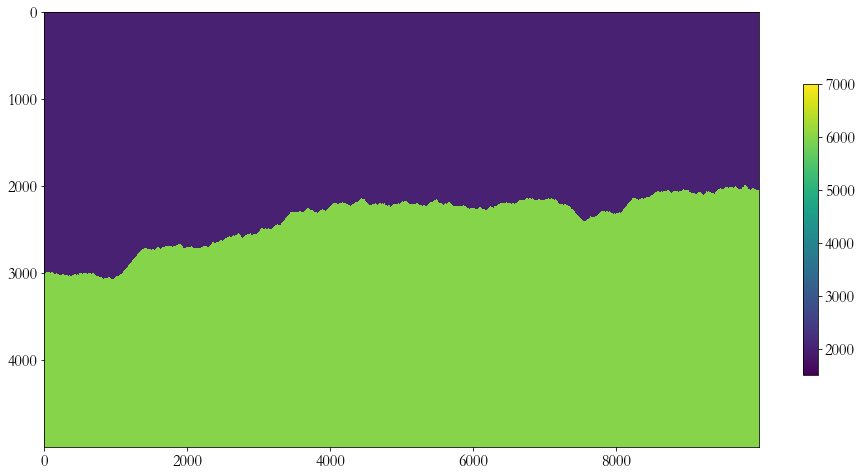

In [14]:
plt.figure(figsize=(16,8))
c1 = plt.imshow(final_grid, interpolation='none', origin="upper", aspect='auto' )
plt.clim(1500,7000)
plt.colorbar(c1, shrink=0.67)
plt.show()

In [15]:
# Export and reload confirming the data is the same:
date = str(datetime.today().strftime('%Y-%m-%d'))
imsave(location_out + date+'_c_1p5.png', final_grid, check_contrast=False)
y = imread(location_out + date+'_c_1p5.png')
(final_grid == y).all()  # True

True

## Interface 1: c=2.0

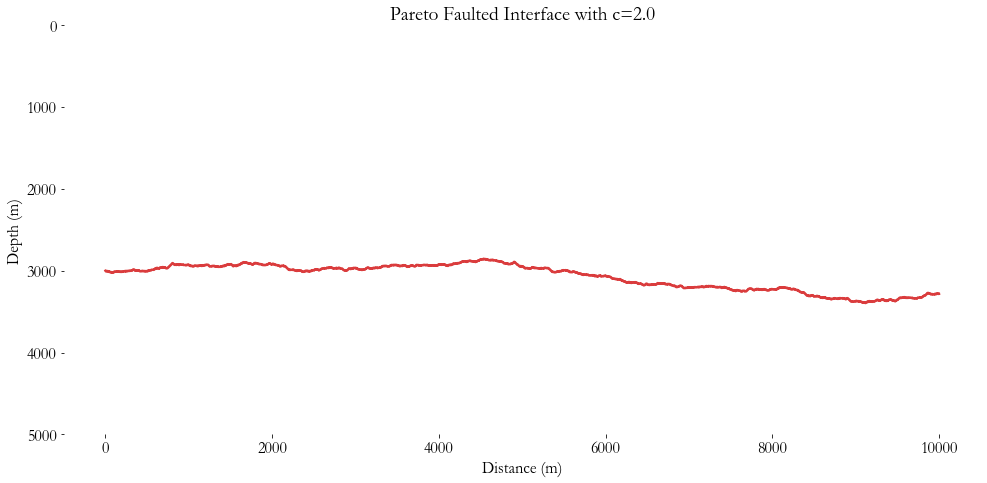

In [16]:
# Load the interface, he values must be integer for setting up the grid
samples = np.loadtxt(location_in+'Pareto_fault_interface_b_2p0.txt', dtype='uint16')
single_plot(samples, D_total=5000, title='Pareto Faulted Interface with c=2.0', step = 1)

LinregressResult(slope=-1.9825930579999385, intercept=-0.359946230558875, rvalue=-0.9580804147370988, pvalue=0.0, stderr=0.015317908202310744)
The slope is -1.98


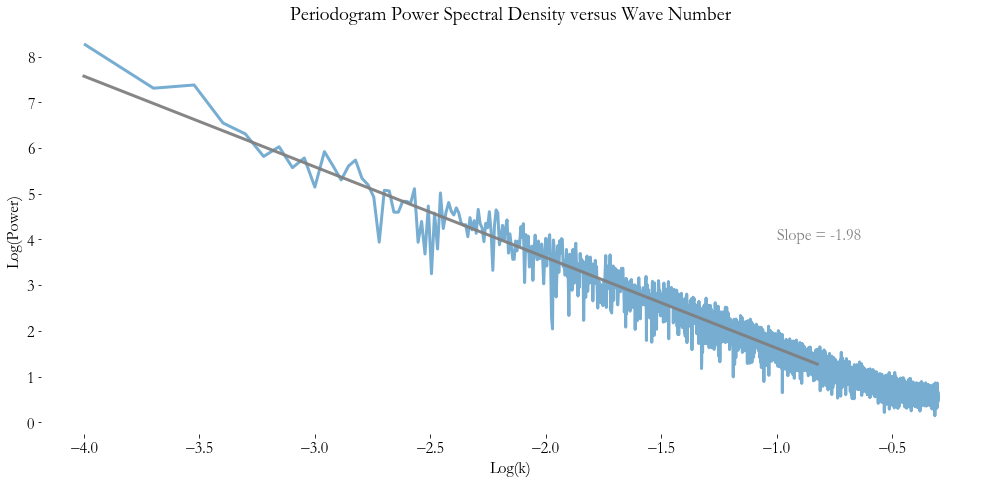

In [17]:
psd_and_slope_plot(samples, f_der_strt=1, f_der_fin=-3500)

### Create model

In [18]:
grid = numpy_grid(L=10000, D=5000)
int_grid = interface_grid(grid, samples, vel=4000)
final_grid = sum_and_shift(int_grid, shift = 2000, conv=True)

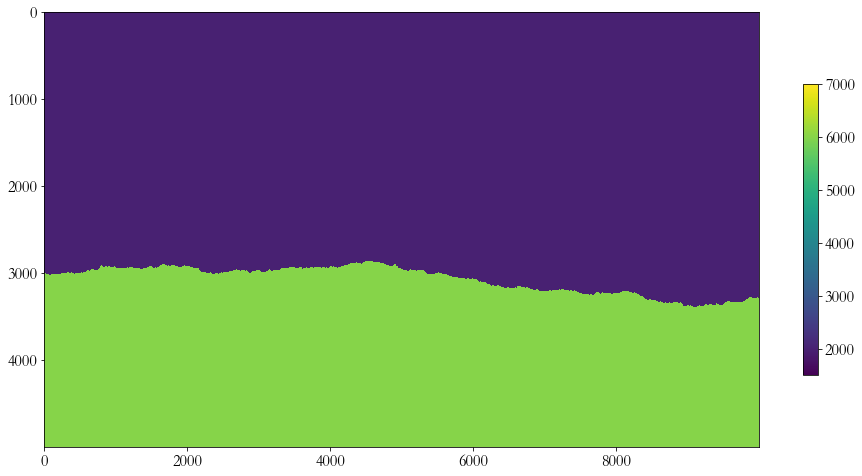

In [19]:
plt.figure(figsize=(16,8))
c1 = plt.imshow(final_grid, interpolation='none', origin="upper", aspect='auto' )
plt.clim(1500,7000)
plt.colorbar(c1, shrink=0.67)
plt.show()

In [20]:
# Export and reload confirming the data is the same:
date = str(datetime.today().strftime('%Y-%m-%d'))
imsave(location_out + date+'_c_2p0.png', final_grid, check_contrast=False)
y = imread(location_out + date+'_c_2p0.png')
(final_grid == y).all()  # True

True